# Implementation of a nonlinear Autoencoder on the MNIST data set

First we import the necessary libraries.

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Next, we load the classical MNIST dataset.

In [49]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Now we define a nonlinear autoencorder neural network, with tied weights, and layers of size (784, 100, 30, 100, 784) accordingly. We use ReLU as the activation function.

In [58]:
x = tf.placeholder(tf.float32, [None, 784], name = "data") #inputs
#first layer
with tf.name_scope("layer1"):
    W1 = tf.Variable(tf.truncated_normal((784, 100) , stddev = 2/np.sqrt(784)), name = "W1")
    b1 = tf.Variable(tf.zeros([100]), name = "b1")
    hidden1 = tf.matmul(xnois,W1)+b1
with tf.name_scope("ReLU1"):
    hidden1eLU = tf.nn.elu(hidden1)
#second layer
with tf.name_scope("layer2"):
    W2 = tf.Variable(tf.truncated_normal((100, 30), stddev = 2/np.sqrt(100)), name = "W2")
    b2 = tf.Variable(tf.zeros([30]), name = "b2")
    hidden2 = tf.matmul(hidden1eLU,W2)+b2
with tf.name_scope("ReLU2"):
    hidden2eLU = tf.nn.elu(hidden2)
    
#third layer
with tf.name_scope("layer3"):
    W3 = tf.transpose(W2, name = "W3")
    b3 = tf.Variable(tf.zeros([100]), name = "b3")
    hidden3 = tf.matmul(hidden2eLU,W3)+b3
with tf.name_scope("ReLU3"):
    hidden3eLU = tf.nn.elu(hidden3)
#output layer
with tf.name_scope("output_layer"):
    W4 = tf.transpose(W1, name = "W4")
    b4 = tf.Variable(tf.zeros([784]), name = "b4")
    outputs = tf.matmul(hidden3eLU,W4)+b4

We will use the L_2 regularizer on the hidden weights and the lossfunctuion is the MSE.

In [59]:
regularizer = tf.contrib.layers.l2_regularizer(0.0001) #add regularizer!
loss = tf.reduce_mean(tf.square(outputs - x)) + regularizer(W1) + regularizer(W2)

With a learningrate of 0.01, we optimize the MSE with AdamOptimzer.

In [60]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

Next we initialize the weights and biases, and save our model in case we want to test different models.

In [61]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let the training begin!

In [62]:
n_epochs = 15
batch_size = 250
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict ={x: x_batch})
            loss_train = loss.eval(feed_dict = {x: x_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
    saver.save(sess, "./autoencoder_tied.ckpt")

0 Train MSE: 0.03330459
1 Train MSE: 0.024626449
2 Train MSE: 0.022898646
3 Train MSE: 0.02226261
4 Train MSE: 0.023485953
5 Train MSE: 0.021441134
6 Train MSE: 0.022820167
7 Train MSE: 0.0220843
8 Train MSE: 0.022048704
9 Train MSE: 0.021408262
10 Train MSE: 0.022301998
11 Train MSE: 0.021990087
12 Train MSE: 0.021897692
13 Train MSE: 0.022199659
14 Train MSE: 0.022047577


Next we implement a function which shows the original input digit, and its reconstruction.

In [63]:
def show_reconstruction(original, model_path = None , n_test_digits = 1):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
            reconstruction = outputs.eval(feed_dict={x: [original]})
  
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    plt.subplot(1, 2, 1)
    plot_image(original)
    plt.subplot(1, 2, 2)
    plot_image(reconstruction)

def plot_image(image, shape = [28,28]):
    plt.imshow(image.reshape(shape), cmap = "Greys", interpolation = "nearest")
    plt.axis("off")
    plt.show()

We test the reconstruction on the first sample of the MNIST dataset.

INFO:tensorflow:Restoring parameters from ./autoencoder_tied.ckpt


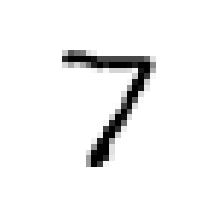

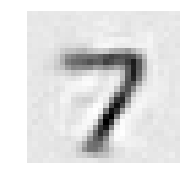

In [64]:
original = mnist.test.images[0]
show_reconstruction(original, "./autoencoder_tied.ckpt",1)

For those who are curious, let's check out how the weights look.

INFO:tensorflow:Restoring parameters from ./autoencoder_tied.ckpt


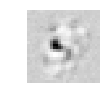

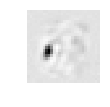

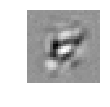

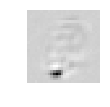

In [65]:
with tf.Session() as sess:
    saver.restore(sess, "./autoencoder_tied.ckpt") 
    weights1_val = W1.eval()

n_features = 4
for i in range(n_features):
    plt.subplot(1, n_features, i + 1)
    plot_image(weights1_val.T[i])
    
plt.show()      

We can also train our autoencoder on (X_noise, X) where X_noise is the original X with some white gaussian noise for example. This helps the autoencoder to get rid of the noise, but this is for another time.